In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 16
sc.set_figure_params(dpi=100,dpi_save=800, figsize=(5,5), frameon=False, format='pdf')
%config InlineBackend.figure_format='retina'

# RNA-seq level analysis

In [3]:
noci_mdata = mu.read('./Results_h5ad/06_noci_mdata_SCENIC_TF.h5mu')

In [15]:
adata = noci_mdata['rna']

In [ ]:
adata.obsm['X_umap'] = noci_mdata.obsm['X_umap'].copy()

## Run GSEA of the 3 gene sets

In [16]:
three_df = pd.read_excel('./3datasets.xlsx')

In [17]:
def mouse_gene(x):
    tmp = ''
    for i in range(len(x)):
        if i==0:
            tmp += x[i].upper() 
        else:
            tmp += x[i].lower()
    return tmp

In [18]:
GenAge = three_df.GenAge[:56].map(mouse_gene).to_list()
CellAge = three_df.CellAge[:525].map(mouse_gene).to_list()

In [2]:
senmayo = pd.read_excel("./SenMayo.xlsx",sheet_name='mouse')['Gene(murine)'].tolist()

In [20]:
GenAge = pd.DataFrame(GenAge, columns=['genesymbol'])
GenAge['geneset'] = 'GenAge'
CellAge = pd.DataFrame(CellAge, columns=['genesymbol'])
CellAge['geneset'] = 'CellAge'
senmayo = pd.DataFrame(senmayo, columns=['genesymbol'])
senmayo['geneset'] = 'SenMayo'

In [21]:
gene_set = pd.concat([GenAge, CellAge])
gene_set.reset_index(drop=True, inplace=True)
gene_set = gene_set[~gene_set.genesymbol.duplicated()]

In [22]:
adata.X = adata.layers['scVI_gene'].copy()

In [23]:
import decoupler as dc
dc.run_gsea(
    adata,
    gene_set,
    source="geneset",
    target="genesymbol",
    use_raw=False,
    verbose=True
)

Running gsea on mat with 76203 samples and 20102 targets for 2 sources.


100%|██████████| 8/8 [1:28:40<00:00, 665.11s/it]


In [24]:
pathways=[
    'GenAge',
    'CellAge'
]
adata.obs[pathways] = adata.obsm["gsea_estimate"][pathways]

In [25]:
sc.tl.score_genes(adata, gene_list=senmayo.genesymbol.tolist(), score_name='SenMayo', use_raw=False, ctrl_size=len(senmayo))

In [26]:
Sen90 = adata.obs.SenMayo.quantile(.9)
Sen90

0.1960209880959172

In [27]:
adata.obs['SASP'] = adata.obs.SenMayo.map(lambda x: 'SASP' if x > Sen90 else 'Others')
adata.obs['SASP'].value_counts()

Others    68582
SASP       7621
Name: SASP, dtype: int64

In [28]:
adata.obs.SenMayo = adata.obs.SenMayo.map(lambda x: 3 if x > 3 else x)

/Users/pax/miniconda3/envs/cellrank2_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


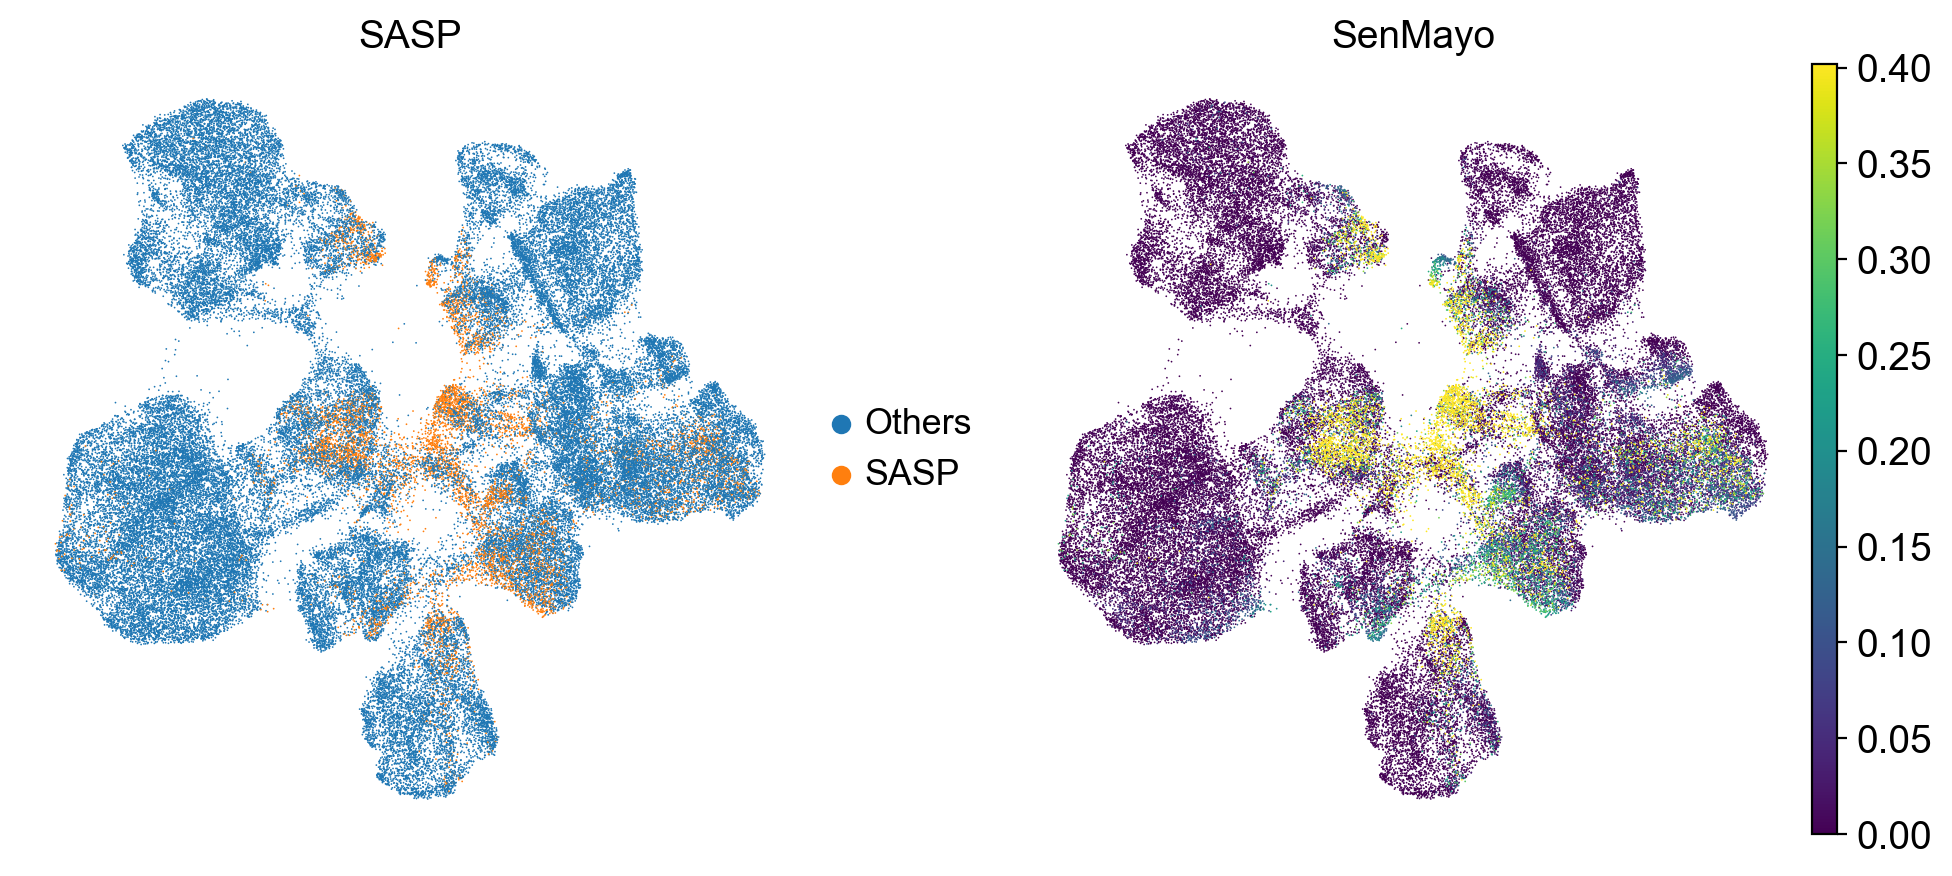

In [32]:
sc.pl.umap(adata, color=['SASP','SenMayo'], vmin=0, vmax='p95')

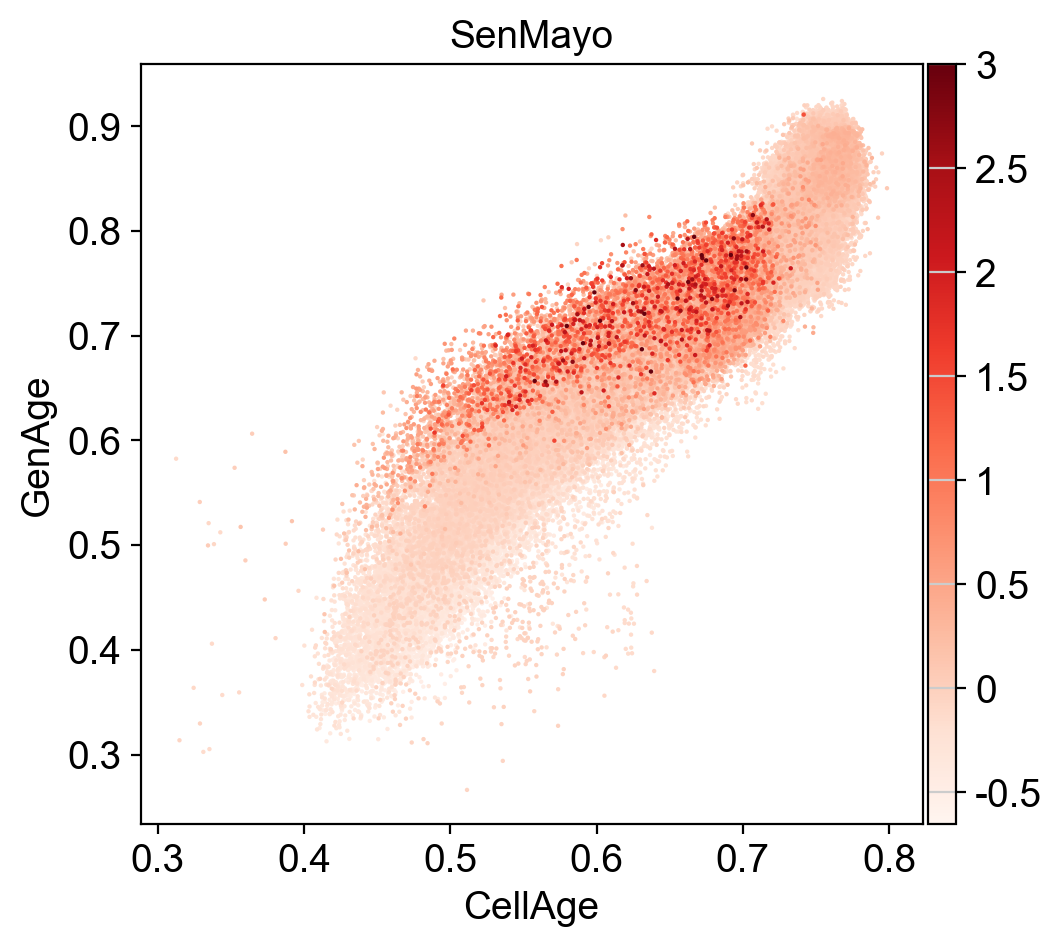

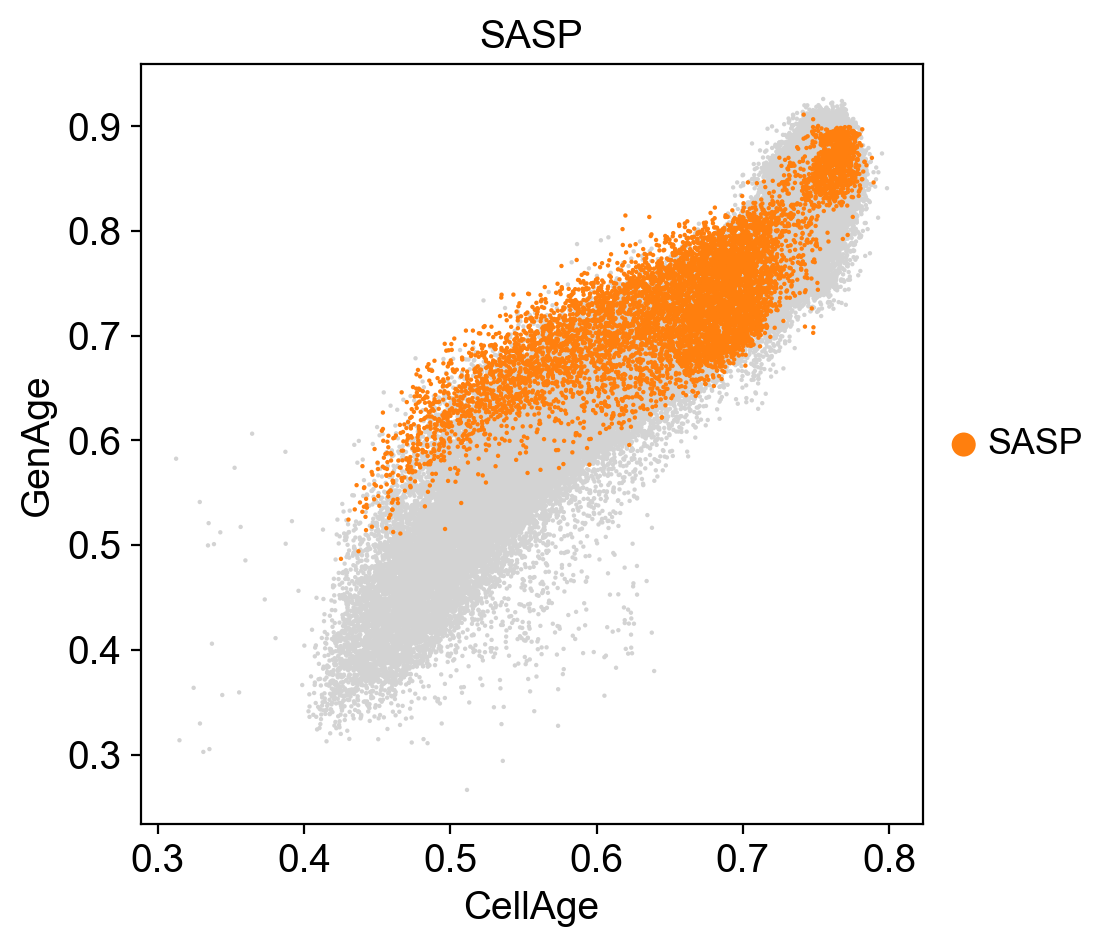

In [33]:
sc.pl.scatter(adata, x='CellAge', y='GenAge', color='SenMayo', size=10, show=False, color_map='Reds').grid(False)
sc.pl.scatter(adata, x='CellAge', y='GenAge', color='SASP', groups='SASP', size=10, show=False).grid(False)


In [156]:
noci_mdata.write('./Results_h5ad/09_noci_mdata_SenMayo.h5mu')

/Users/pax/miniconda3/envs/cellrank2_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [2]:
noci_mdata = mu.read('./Results_h5ad/09_noci_mdata_SenMayo.h5mu')

In [3]:
obs_ = pd.read_csv('./noci_obs_cellrank2_CytoTRACE_prep.csv', index_col=0)
noci_mdata = noci_mdata[obs_.index].copy()
obs_['Pain_dynamics'] = obs_['Pain_dynamics'].astype('category').cat.reorder_categories(['Reference','Moving','Pain','Recovery','Stuck'])
noci_mdata.obs['Pain_dynamics'] = obs_['Pain_dynamics'].copy()
noci_mdata['rna'].obs['Pain_dynamics'] = noci_mdata.obs['Pain_dynamics'].copy()
noci_mdata['atac'].obs['Pain_dynamics'] = noci_mdata.obs['Pain_dynamics'].copy()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_81167/2885014949.py:1: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_ = pd.read_csv('./noci_obs_cellrank2_CytoTRACE_prep.csv', index_col=0)


In [4]:
noci_mdata['rna'].obs['PainCon'] = noci_mdata.obs['PainCon'].copy()
noci_mdata['atac'].obs['PainCon'] = noci_mdata.obs['PainCon'].copy()

In [5]:
sc.tl.rank_genes_groups(noci_mdata['rna'], groupby='PainCon', method='t-test_overestim_var', use_raw=False, layer='scVI_gene')

In [5]:
adata = noci_mdata['rna']

In [59]:
# adata.write('./Results_h5ad/adata_pain_dynamics.h5ad')

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWar

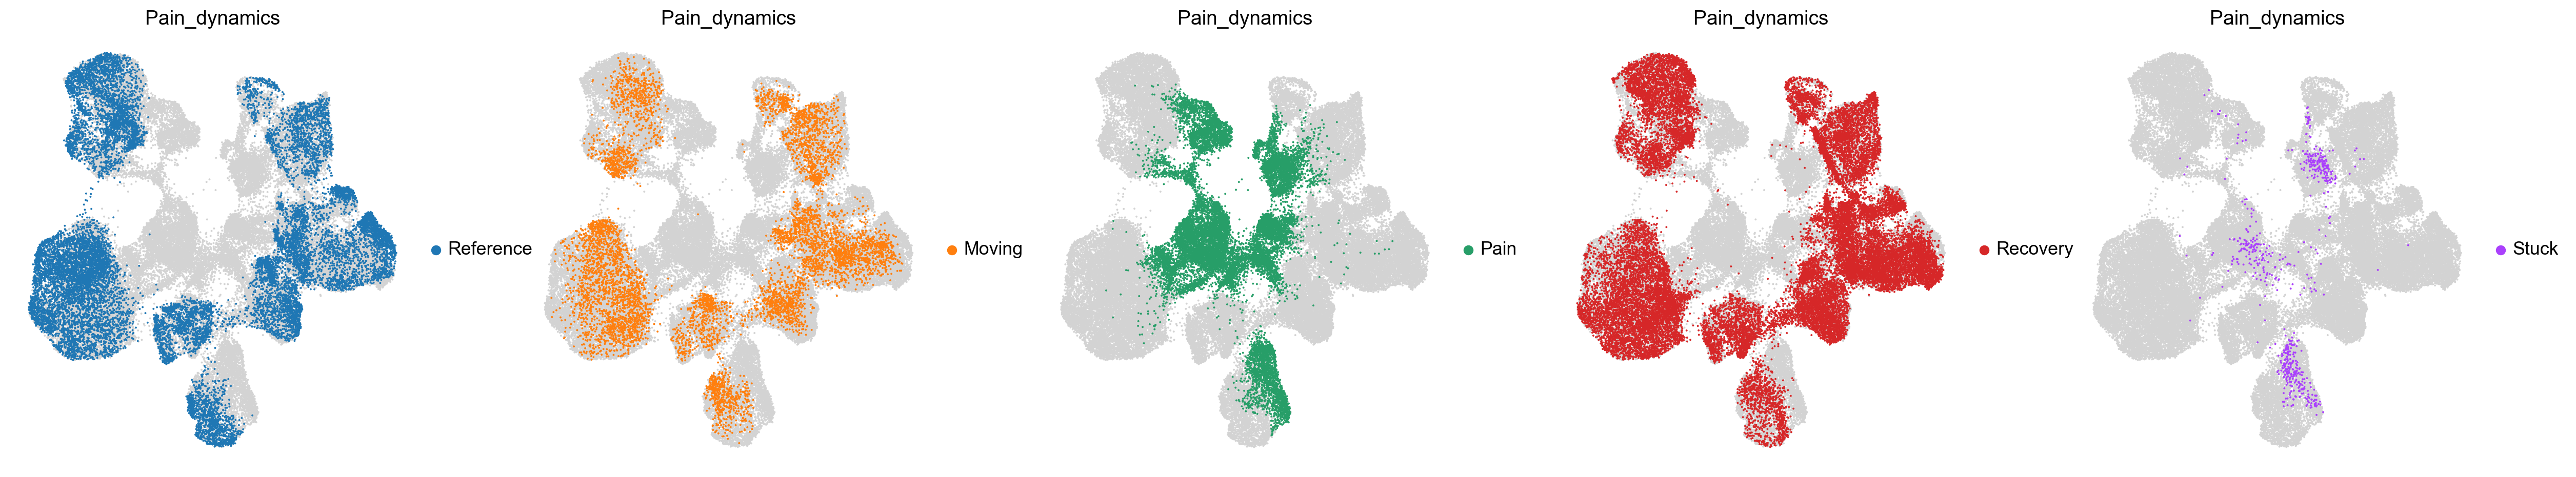

In [41]:
fig, ax = plt.subplots(1,len(adata.obs.Pain_dynamics.cat.categories),figsize=(25,5))
fig.tight_layout(w_pad=3)
for i,c in enumerate(adata.obs.Pain_dynamics.cat.categories):
    sc.pl.umap(adata, color='Pain_dynamics', groups=c, show=False, na_in_legend=False, ax=ax[i], s=8)
fig.savefig('/Users/pax/Manu_fig/eps/umap_Pain_dynamics.eps', dpi=300, bbox_inches='tight')

In [8]:
df_plt = adata.obs[adata.obs.Time.isin(['0day', '1day', '7day','14day', '28day'])]
df_plt.Time = df_plt.Time.cat.remove_unused_categories()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_31357/3208426337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt.Time = df_plt.Time.cat.remove_unused_categories()


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_31357/2214489599.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


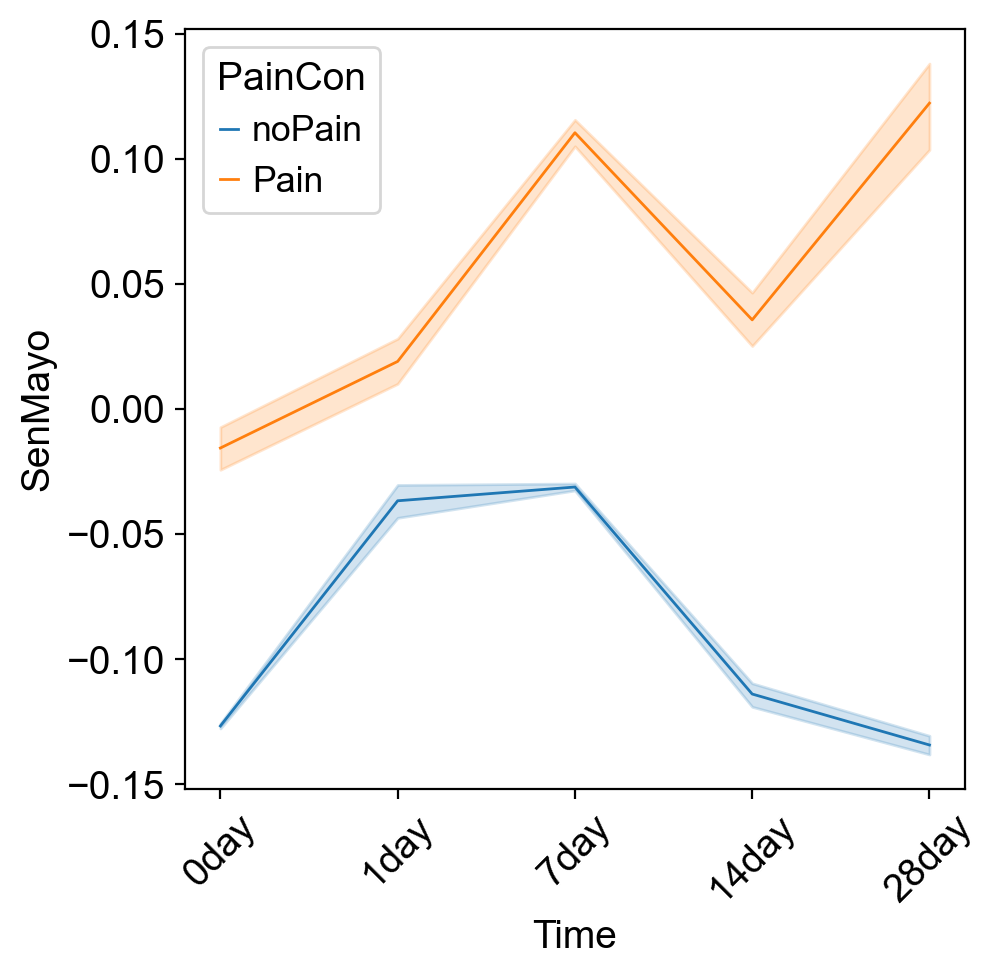

In [12]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.lineplot(x='Time', y='SenMayo',
             data=df_plt, hue='PainCon',
             errorbar=('ci', 68), lw=1, markers=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(False)

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


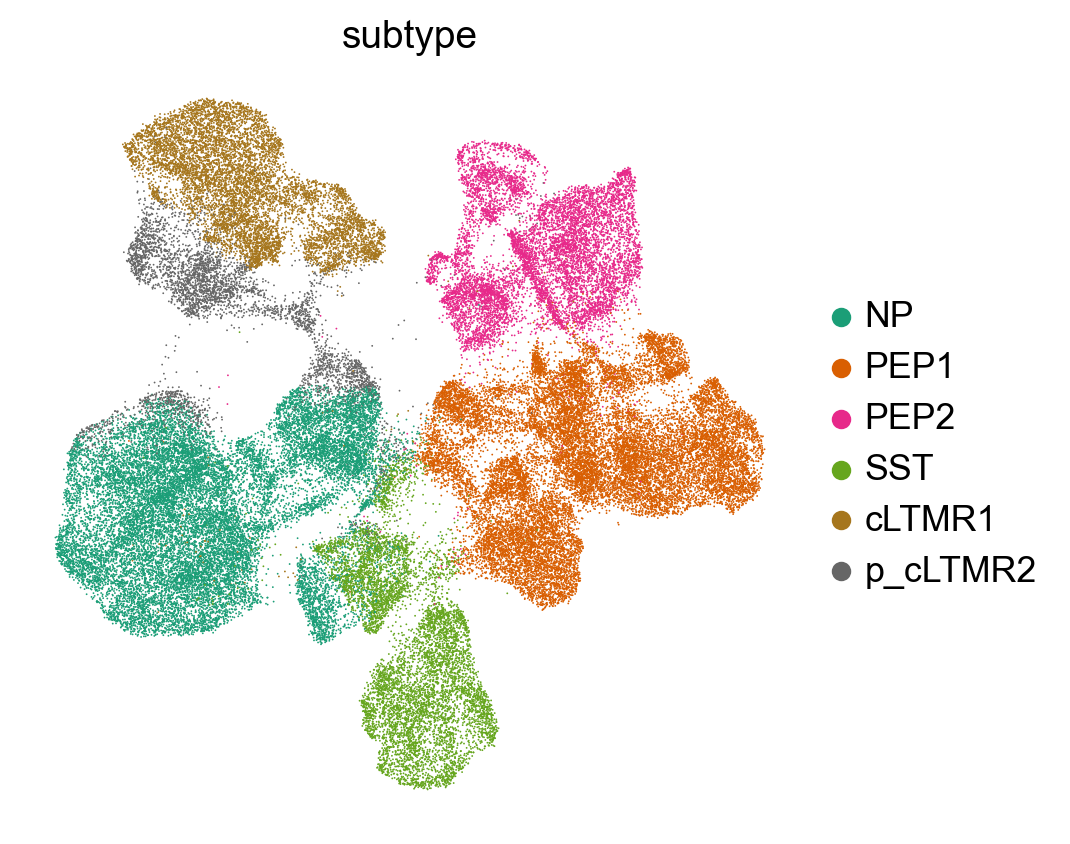

In [42]:
fig, ax = plt.subplots(figsize=(5,5))
mu.pl.umap(noci_mdata, color='subtype', palette='Dark2', ax=ax, show=False)
fig.savefig('/Users/pax/Manu_fig/eps/umap_noci_subtype_Dark2.eps', bbox_inches='tight')

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'subtype'}, xlabel='X_umap1', ylabel='X_umap2'>

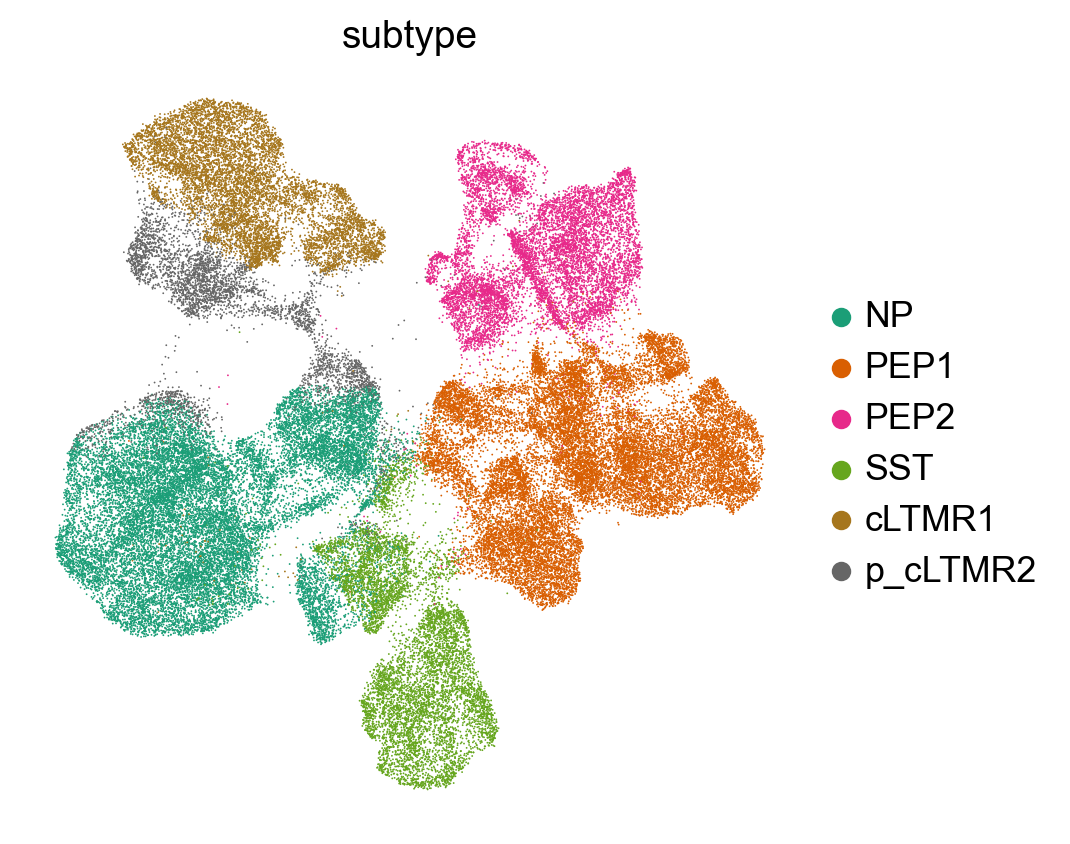

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
mu.pl.umap(noci_mdata, color='subtype', palette='Dark2', ax=ax, show=False)
fig.savefig('/Users/pax/Manu_fig/umap_noci_subtype_Dark2.pdf', bbox_inches='tight')

In [8]:
palette = dict(zip(adata.obs.Pain_dynamics.cat.categories,adata.uns['Pain_dynamics_colors']))

In [9]:
Pain_dynamics = adata.obs.Pain_dynamics.cat.categories
adata.obs.Pain_dynamics = adata.obs.Pain_dynamics.astype(str)

In [13]:
from scipy import stats
a = adata.obs.SenMayo[adata.obs['Pain_dynamics'] == 'Recovery']
b = adata.obs.SenMayo[adata.obs['Pain_dynamics'] == 'Pain']
mann = stats.mannwhitneyu(a, b, alternative='less')
mann

MannwhitneyuResult(statistic=160074593.0, pvalue=0.0)

In [14]:
a = adata.obs.SenMayo[adata.obs['Pain_dynamics'] == 'Recovery']
b = adata.obs.SenMayo[adata.obs['Pain_dynamics'] == 'Stuck']
mann = stats.mannwhitneyu(a, b, alternative='less')
mann

MannwhitneyuResult(statistic=5956042.0, pvalue=1.6069456758861724e-54)

In [67]:
from scipy import stats

for g in Pain_dynamics[1:]:
    a = adata.obs.SenMayo[adata.obs['Pain_dynamics'] == 'Reference']
    b = adata.obs.SenMayo[adata.obs['Pain_dynamics'] == g]
    mann = stats.mannwhitneyu(a, b, alternative='less')
    print(f'{g}: pval {mann[-1]}')

Moving: pval 1.0
Pain: pval 0.0
Recovery: pval 1.1915111952257478e-209
Stuck: pval 2.2434342510891976e-114


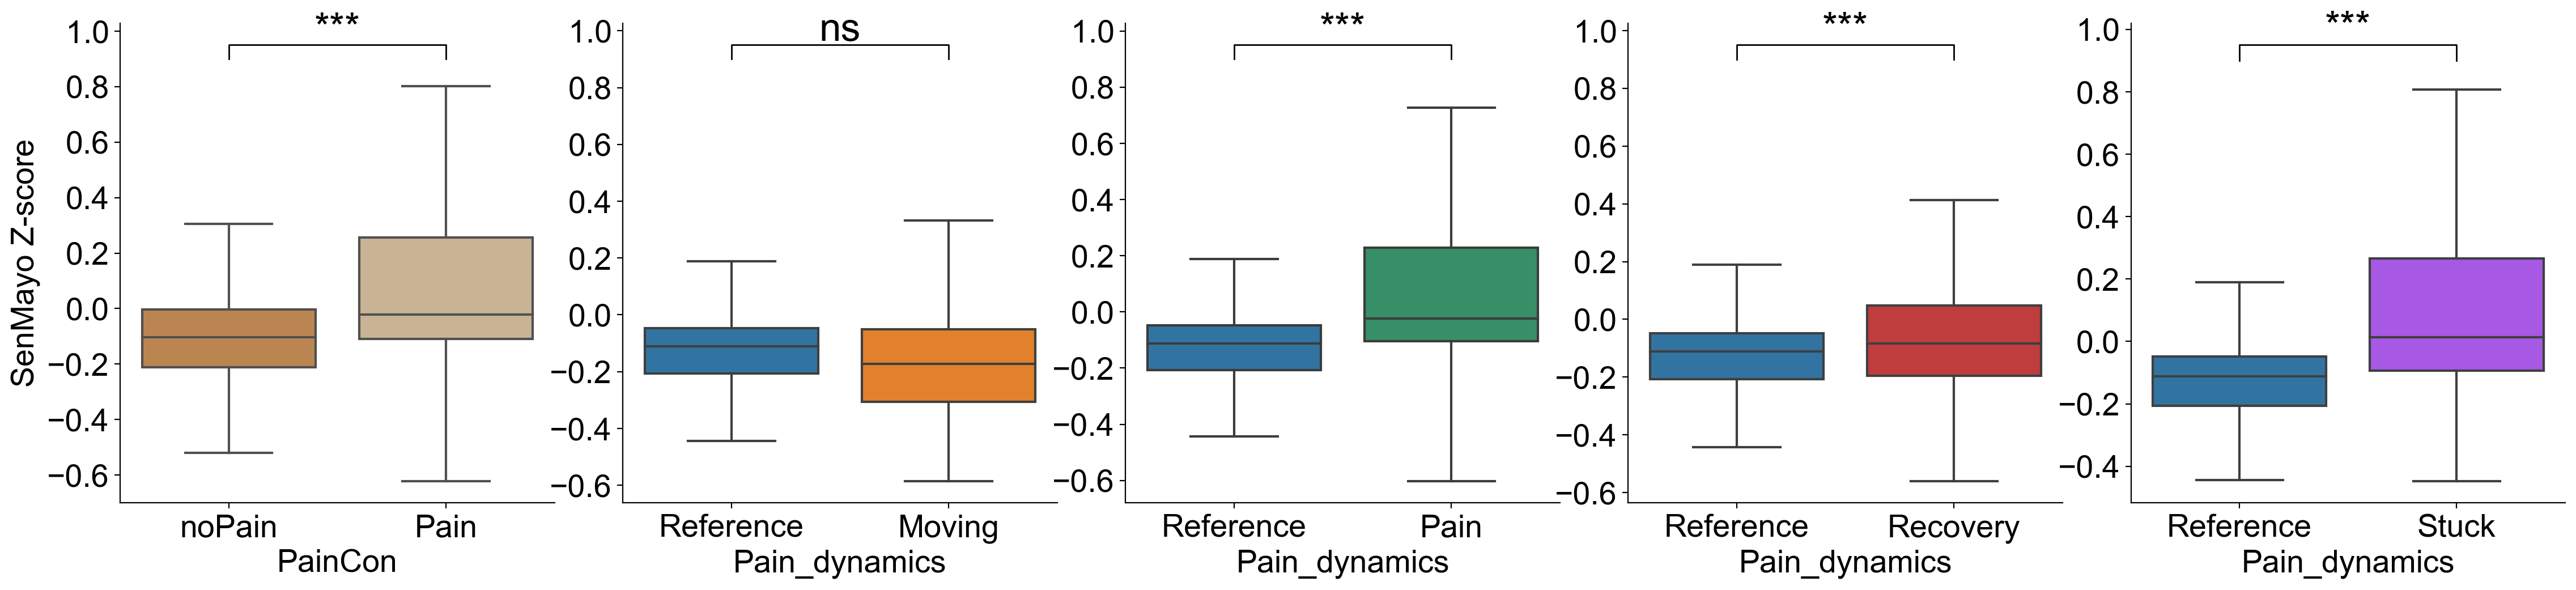

In [19]:
fig, ax = plt.subplots(1,1*len(Pain_dynamics),figsize=(4.5*len(Pain_dynamics),5))
ax = ax.ravel()
fig.tight_layout(w_pad=0.5)
for i,g in enumerate(Pain_dynamics):
    
    # main boxplot
    if i > 0:
        sns.boxplot(x='Pain_dynamics', y='SenMayo', data=adata.obs[adata.obs.Pain_dynamics.isin(['Reference',g])],
                    ax=ax[i], showfliers=False, palette=palette, order=['Reference',g])
    else:
        sns.boxplot(x='PainCon', y='SenMayo', data=adata.obs, ax=ax[0], showfliers=False, palette={'noPain':'peru','Pain':'tan'})

    # plot significance
    signi='***'
    if i == 0:
        ax[i].set_ylabel('SenMayo Z-score')
    elif i == 1:
        signi='ns'
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('')
    max_val = 0.8
    ax[i].plot([0,0,1,1], [max_val+0.1, max_val+0.15, max_val+0.15, max_val+0.1], lw=1, c='k')
    ax[i].text(0.5, max_val+0.2, signi, ha='center', va='center', fontsize=25)

    # adjust aestatics
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(False)
    for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] +ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        item.set_fontsize(20)
fig.savefig(f'/Users/pax/Manu_fig/eps/boxplot_SenMayo_PainState&dynamics.eps', bbox_inches='tight')

In [6]:
adata.uns['SASP_colors'] = ['#000080','#ff1493']

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


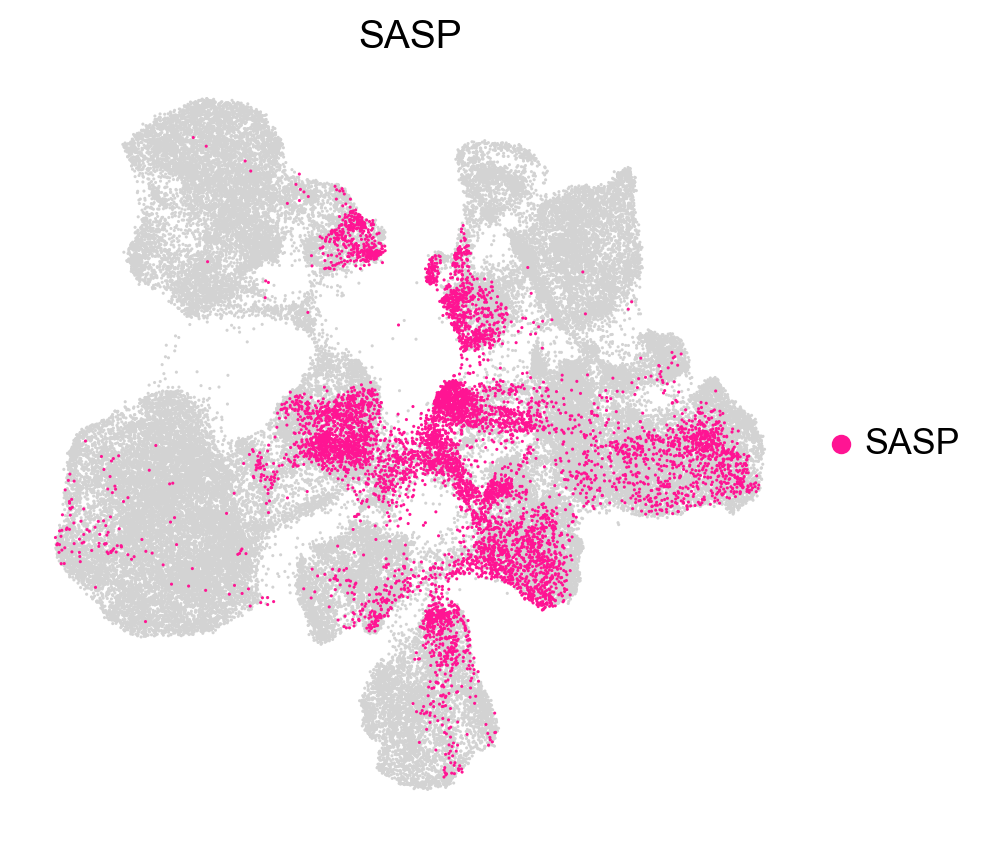

In [133]:
sc.pl.umap(adata, color=['SASP'], groups='SASP', na_in_legend=False, s=5, save='_SASP.pdf')

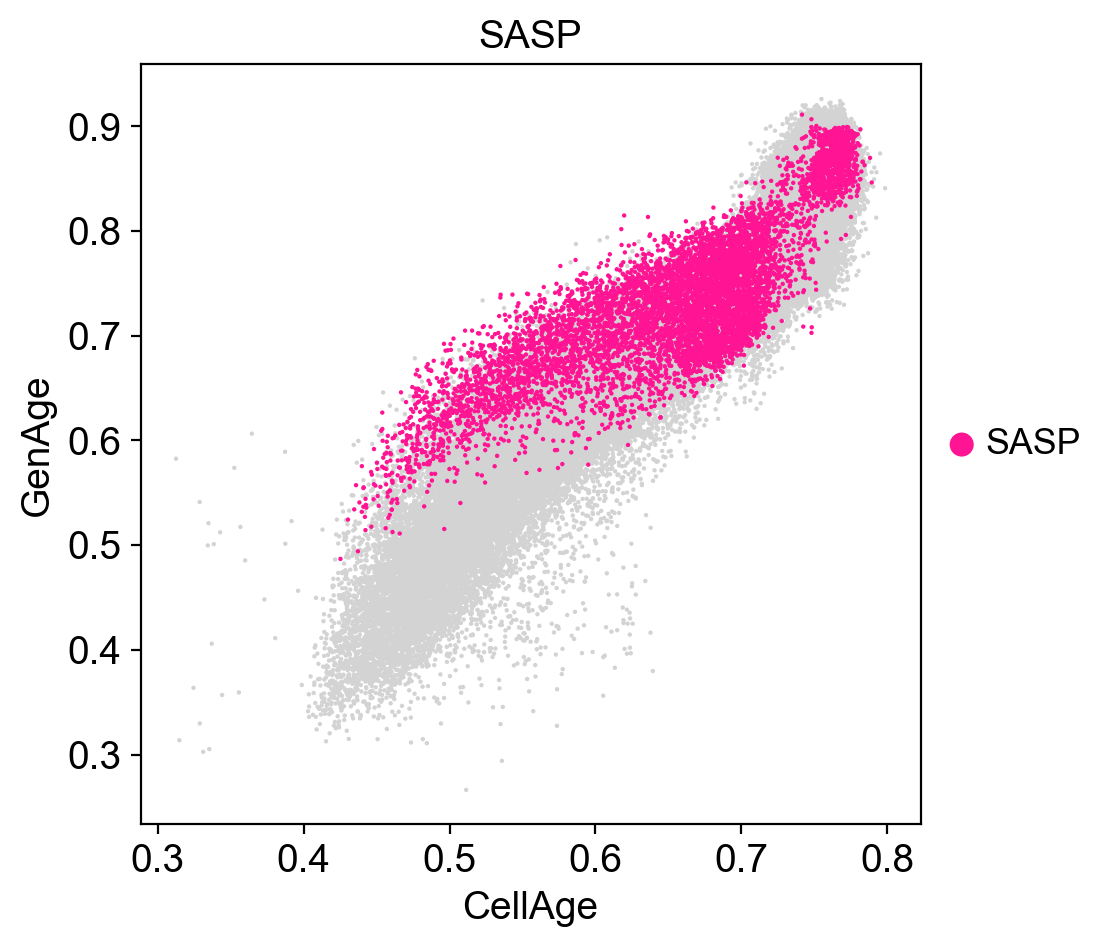

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
sc.pl.scatter(adata, x='CellAge', y='GenAge', color='SASP', groups='SASP', size=10, show=False, ax=ax)
ax.grid(False)
fig.savefig('/Users/pax/Manu_fig/scatter_SASP_cloud.pdf', bbox_inches='tight')

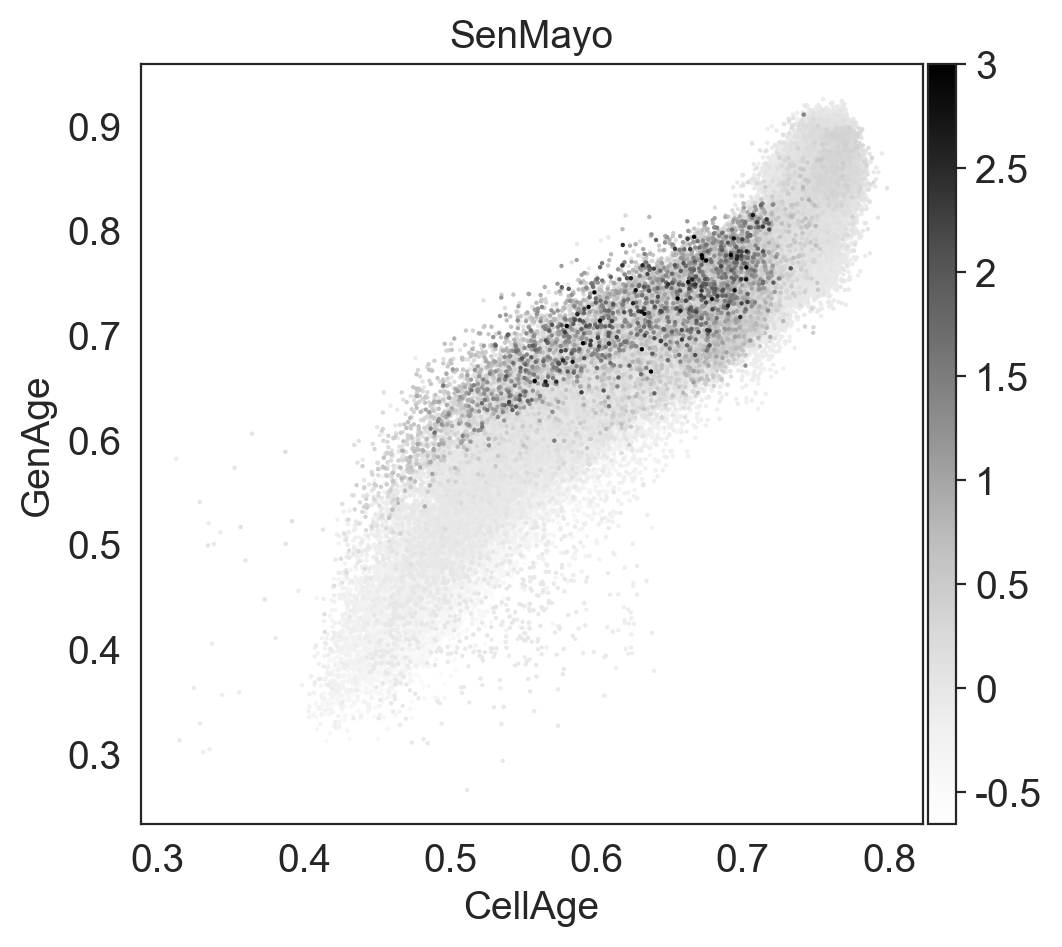

In [58]:
sns.set_style('white')
sc.pl.scatter(adata, x='CellAge', y='GenAge', color='SenMayo', color_map='Greys', size=10, show=True, save='_SenMayo_score')

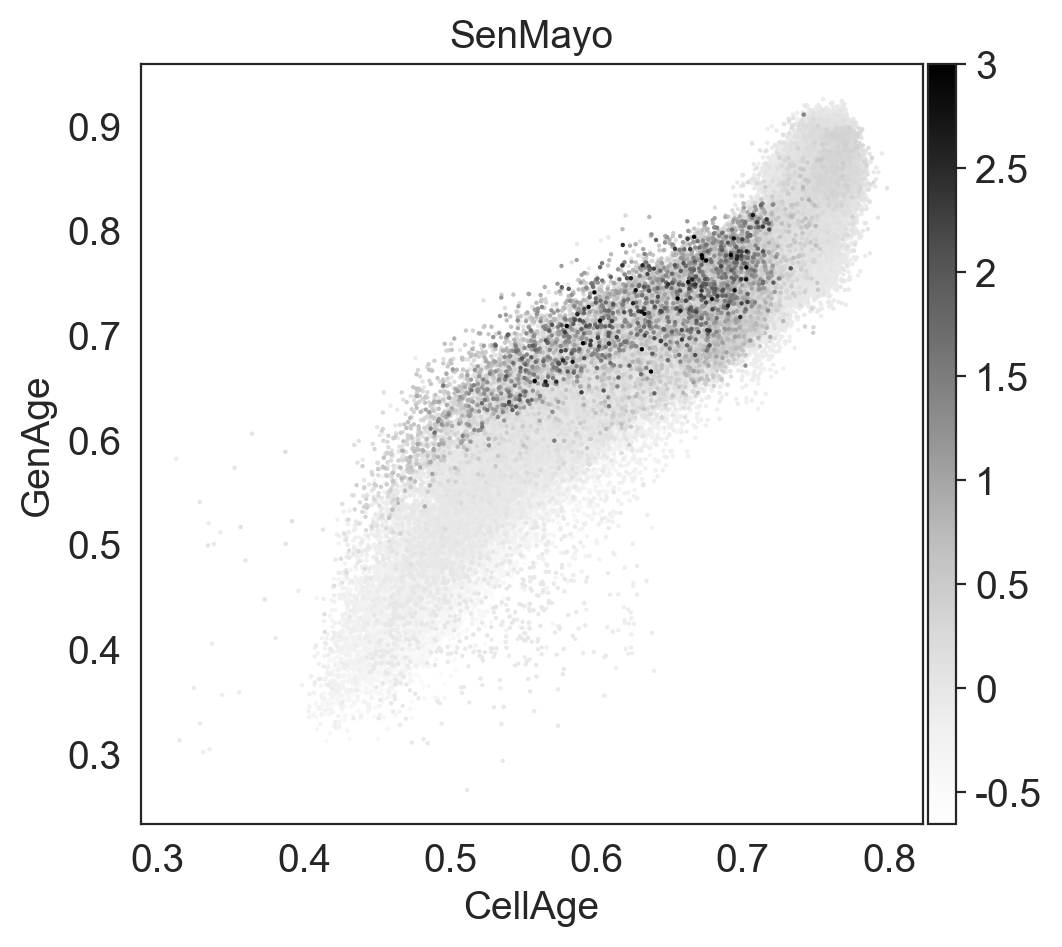

In [139]:
sns.set_style('white')
sc.pl.scatter(adata, x='CellAge', y='GenAge', color='SenMayo', color_map='Greys', size=10, show=True, save='_SenMayo_score.pdf')

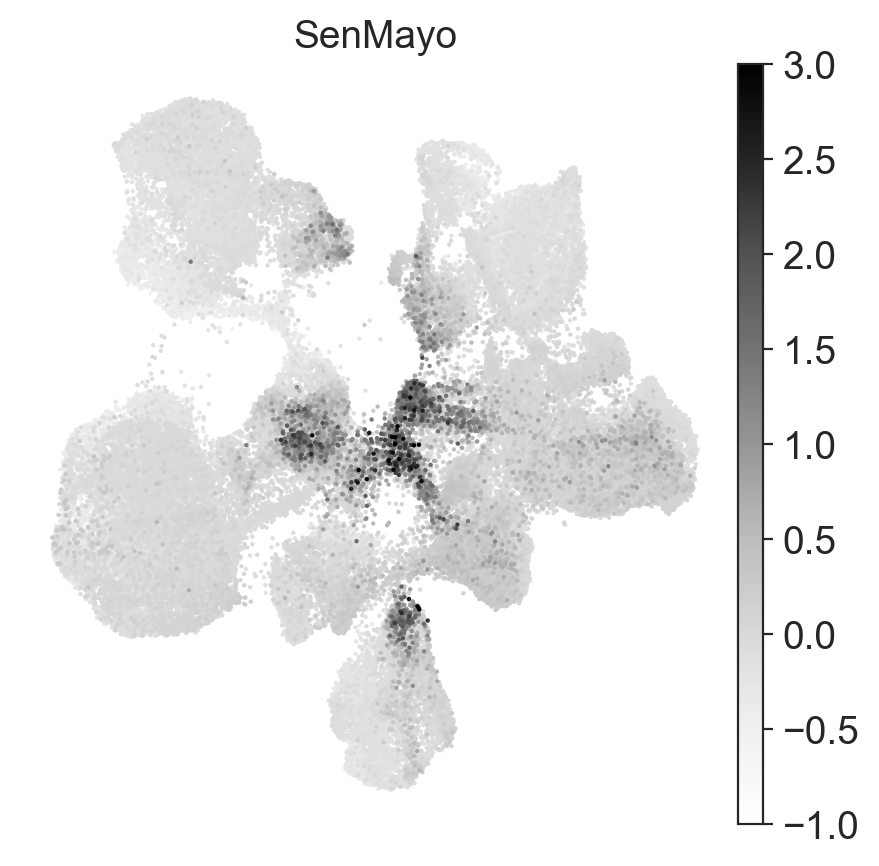

In [140]:
sc.pl.umap(adata, color=['SenMayo'], cmap='Greys', vmin=-1, vmax=3, s=10, save='_SenMayo_score.pdf')

In [4]:
from scipy import stats

a = adata.obs.SenMayo[adata.obs['PainCon'] == 'noPain']
b = adata.obs.SenMayo[adata.obs['PainCon'] == 'Pain']
stats.mannwhitneyu(a, b, alternative='less')

TtestResult(statistic=-61.775492381696075, pvalue=0.0001312163758037003, df=nan)

In [169]:
sns.set_style('white')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


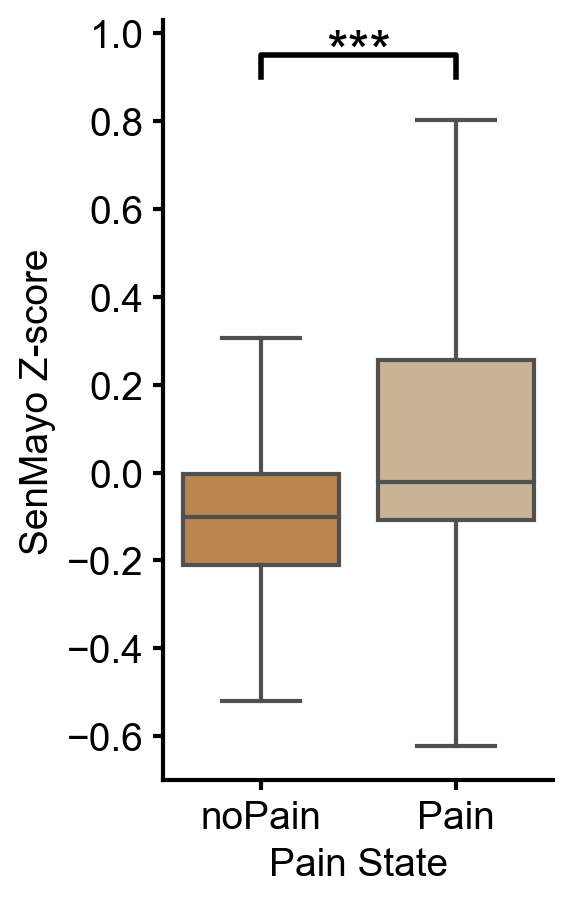

In [6]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(2.5,5))
sns.boxplot(x='PainCon', y='SenMayo', data=adata.obs, ax=ax, showfliers=False, palette={'noPain':'peru','Pain':'tan'})
# sns.swarmplot(x='PainCon', y='SenMayo', data=adata.obs, ax=ax, size=5, hue='PainCon')

# max_val = max(adata.obs.SenMayo)
max_val = 0.8
plt.plot([0,0,1,1], [max_val+0.1, max_val+0.15, max_val+0.15, max_val+0.1], lw=2, c='k')
plt.text(0.5, max_val+0.15, '***', ha='center', va='center', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.tick_params(width=1.5)
ax.grid(False)
ax.set_xlabel('Pain State')
ax.set_ylabel('SenMayo Z-score')
ax.legend(loc='upper right', bbox_to_anchor=(1.05,1), frameon=False)
fig.savefig('/Users/pax/Manu_fig/boxplot_SenMayo.pdf', bbox_inches='tight')

In [158]:
from scipy import stats

a = adata.obs.SenMayo[(adata.obs['Sex'] == 'female') & (adata.obs['PainCon'] == 'noPain')]
b = adata.obs.SenMayo[(adata.obs['Sex'] == 'female') & (adata.obs['PainCon'] == 'Pain')]
stats.mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=28572425.0, pvalue=1.1774720835075151e-30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


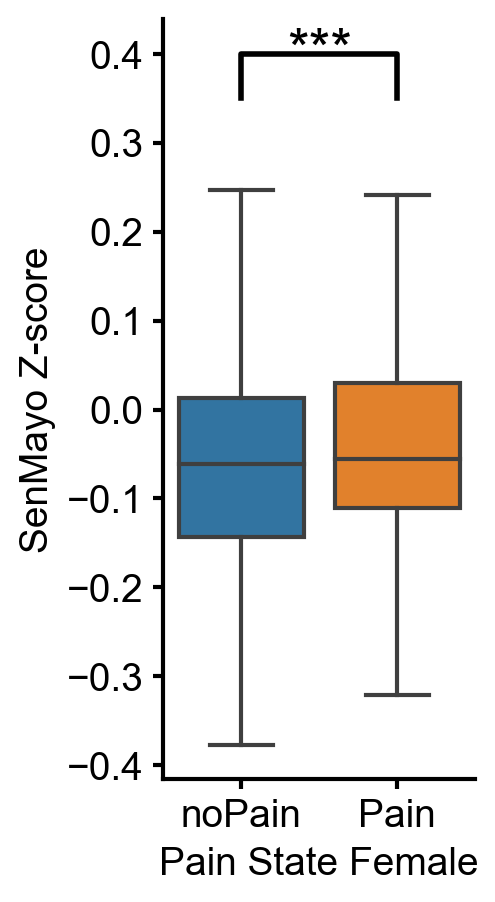

In [6]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(2,5))
sns.boxplot(x='PainCon', y='SenMayo', data=adata.obs[(adata.obs['Sex'] == 'female')], ax=ax, showfliers=False)
# sns.swarmplot(x='Sex', y='SenMayo', data=adata.obs, ax=ax, size=5, hue='Sex')

# max_val = max(adata.obs.SenMayo)
max_val = 0.25
plt.plot([0,0,1,1], [max_val+0.1, max_val+0.15, max_val+0.15, max_val+0.1], lw=2, c='k')
plt.text(0.5, max_val+0.15, '***', ha='center', va='center', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.tick_params(width=1.5)
ax.grid(False)
ax.set_xlabel('Pain State Female')
ax.set_ylabel('SenMayo Z-score')
ax.legend(loc='upper right', bbox_to_anchor=(1.05,1), frameon=False)
# fig.savefig('/Users/pax/Manu_fig/boxplot_SenMayo_sex.pdf', bbox_inches='tight')

In [160]:
from scipy import stats

a = adata.obs.SenMayo[(adata.obs['Sex'] == 'male') & (adata.obs['PainCon'] == 'noPain')]
b = adata.obs.SenMayo[(adata.obs['Sex'] == 'male') & (adata.obs['PainCon'] == 'Pain')]
stats.mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=112628584.0, pvalue=0.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


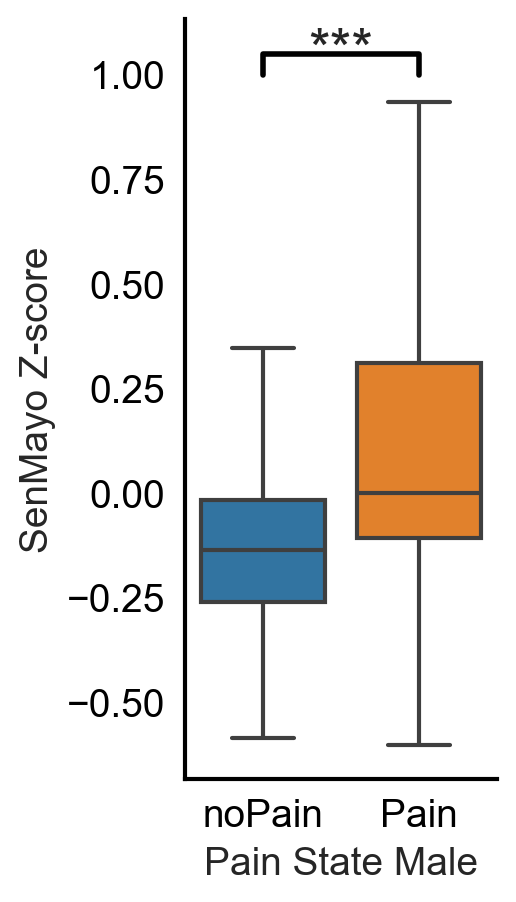

In [165]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(2,5))
sns.boxplot(x='PainCon', y='SenMayo', data=adata.obs[(adata.obs['Sex'] == 'male')], ax=ax, showfliers=False)
# sns.swarmplot(x='Sex', y='SenMayo', data=adata.obs, ax=ax, size=5, hue='Sex')

# max_val = max(adata.obs.SenMayo)
max_val = 0.9
plt.plot([0,0,1,1], [max_val+0.1, max_val+0.15, max_val+0.15, max_val+0.1], lw=2, c='k')
plt.text(0.5, max_val+0.15, '***', ha='center', va='center', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.tick_params(width=1.5)
ax.grid(False)
ax.set_xlabel('Pain State Male')
ax.set_ylabel('SenMayo Z-score')
ax.legend(loc='upper right', bbox_to_anchor=(1.05,1), frameon=False)
# fig.savefig('/Users/pax/Manu_fig/boxplot_SenMayo_sex.pdf', bbox_inches='tight')